# Perturbation for cross-feeding consumer resource model 

In [1]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns 
import cvxpy as cvx
import time
from collections import  defaultdict
import copy
from __future__ import division
import pandas as pd
from numpy.random import dirichlet
import numbers
from community_simulator import *
from community_simulator.usertools import *
from community_simulator.essentialtools import *
from community_simulator.visualization import *
import seaborn as sns
from joblib import Parallel, delayed
import pandas as pd
from itertools import product
#from tqdm import tqdm
from tqdm.notebook import tqdm
import pickle
import os
import time
from multiprocess import Pool

from sklearn.metrics import confusion_matrix, r2_score, ConfusionMatrixDisplay
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize, BoundaryNorm
# Function to format ticks as 10^(log(error))
def log_formatter(x, pos):
    return f'$10^{{{int(x)}}}$'
from iterative_perturbation import general_perturbation_prediction
from iterative_perturbation import prediction_given_Sbool



Our focus in this document is the microbial cross-feeding model
\begin{align}
    \frac{dN_i}{dt}&=N_i(\sum_\alpha (1-l_\alpha)w_\alpha c_{i\alpha}R_\alpha-m_i)\\
    \frac{dR_\alpha}{dt}&=K_\alpha -\omega R_\alpha - \sum_j c_{j\alpha }N_j R_\alpha +\sum_{j,\beta}l_\beta \frac{w_\alpha}{w_\beta}D_{\alpha \beta}c_{j\beta}R_\beta N_j
\end{align}

Many paramters are involved: two matrice $c_{i\alpha}$ and $D_{\alpha \beta}$ vectors $w$, $l$, $K$. In the community simulator package, $\omega$ maps to $1/\tau$, and $K_\alpha$ maps to $(R_0)_\alpha/\tau$, and $l$ is a constant from 0 to 1 instead of a vector, and w is also a constant set to 1 often. Furthermore, $D_{\alpha \beta}$ is sampled from Dirichlet distribution.
i.e.
\begin{align}
    \frac{dN_i}{dt}&=N_i(\sum_\alpha (1-l) c_{i\alpha}R_\alpha-m_i)\\
    \frac{dR_\alpha}{dt}&=R^0_\alpha -R_\alpha - \tau\sum_j c_{j\alpha }N_j R_\alpha +\tau\sum_{j,\beta}l D_{\alpha \beta}c_{j\beta}R_\beta N_j
\end{align}


It can be lineared to general consumer resource model 

\begin{align}
\frac{dN_i}{dt}&=N_i(\sum_\alpha C_{i\alpha}R_\alpha-m_i)\\
\frac{dR_\alpha}{dt}&=R_\alpha(K_\alpha - \sum_\beta Q_{\alpha \beta} R_\beta-\sum_j E_{j\alpha}N_j) .
\label{eq: general MCRM}
\end{align}



with effective interactions

\begin{align}
C_{i\alpha}&=(1-l_\alpha)w_\alpha c_{i\alpha}\\
E_{i\alpha}&=- \kappa_{i\alpha}^{eff}/\omega\\
    Q_{\alpha \beta}&=-\frac{\partial }{\partial R_{\beta}}(\frac{K_\alpha}{\omega} -  R_\alpha + \sum_j \frac{\kappa_{i\alpha}^{eff}}{\omega}N_j)\\
    &=\delta_{\alpha \beta}(1 +\frac{1}{\omega}\sum_j c_{j\alpha }N_j)-l_\beta \frac{w_\alpha}{w_\beta}D_{\alpha \beta}\sum_{j}c_{j\beta} N_j
\end{align}
where 
\begin{align}
    \kappa_{i\alpha}^{eff}=-c_{i\alpha}R_\alpha^*+\sum_{\beta}l_\beta \frac{w_\alpha}{w_\beta}D_{\alpha \beta}c_{i\beta}R_\beta
\end{align}


or in the simpler case of constant $l$ and $w=1$,

\begin{align}
C_{i\alpha}&=(1-l) c_{i\alpha}\\
E_{i\alpha}&=- \tau c_{i\alpha}R_\alpha+\sum_{\beta}l D_{\alpha \beta}c_{i\beta}R_\beta\\
    Q_{\alpha \beta}&=\delta_{\alpha \beta}(1 +\tau\sum_j c_{j\alpha }N_j)-l D_{\alpha \beta}\sum_{j}c_{j\beta} N_j
\end{align}


In [2]:
def form_matrices(c, N, R, D, l, tau, get_Q=True):
    #noted all input matrices and vectors are defined for surviving species
    """
    Form the effective matrices C, E, and Q according to the given formulas using NumPy matrix operations.
    
    Parameters:
    c (np.ndarray): Consumption matrix with shape (S*, M*).
    N (np.ndarray): Vector of species abundances with shape (S*,).
    R (np.ndarray): Vector of resource concentrations with shape (M*,).
    D (np.ndarray): Diffusion matrix with shape (M*, M*).
    l (float): Fraction of byproducts.
    tau (float): Turnover rate.

    Returns:
    C_matrix (np.ndarray): Matrix C with shape (S*, M*).
    E_matrix (np.ndarray): Matrix E with shape (S*, M*).
    Q_matrix (np.ndarray): Matrix Q with shape (M*, M*).
    """
    # Calculate C_matrix
    C_matrix = (1 - l) * c
    
    # Calculate E_matrix
    E_matrix= -(-tau * (c * R)+l * (D @ (c * R).T).T)
    # Calculate Q_matrix
    if get_Q: Q_matrix = np.eye(c.shape[1]) * (1 + tau * c.T@ N) - l * D * np.dot(c.T, N)
    else:Q_matrix = None
        
    return C_matrix, E_matrix, Q_matrix

def eff_invader_fitness_given_Sbool(A,X,u,delta_u,A_II,A_IS,A_SI, u_I,Sbool,Sbool_I,knock_off): 
    num_invaders=len(u_I)
    
    #to get effective invasion fitness, treat as if invader survive
    Sbool_I=np.array([True]*len(Sbool_I),dtype=bool)
    
    Ebool_I= np.logical_not(Sbool_I)
    Ebool= np.logical_not(Sbool)
    not_knock_off=np.logical_not(knock_off)
    Ebool[knock_off]=True
    X_I=np.zeros(num_invaders)
    deltaX=np.zeros(len(A))
    
    X_S = X[Sbool]
    X_E = X[Ebool]
    A_SS_inv=np.linalg.inv(A[Sbool,::][::,Sbool])
    A_SE=A[Sbool,::][::,Ebool]
    delta_u_S=delta_u[Sbool]
    A_IS_s=A_IS[Sbool_I,::][::,Sbool]
    A_SI_s=A_SI[Sbool,::][::,Sbool_I]
    A_II_s=A_II[Sbool_I,::][::,Sbool_I]  
    u_I_s=u_I[Sbool_I]
    X_I_s=X_I[Sbool_I]
    
    return -(u_I_s-A_IS_s@X_S-A_IS_s@A_SS_inv@(delta_u_S+A_SE@X_E))
    
def predict_CRM_invader_fitness_with_LV(Cs,Es,Qs,oldNs,oldRs,ms,k,E_I, C_I, m_I,delta_m,knock_off,N_simulator_Sbool,R_simulator_Sbool):
    resources=len(k)
    num_invaders=len(m_I)
    num_native=len(Cs)
    
    As=make_A(Cs,Es,Qs)
    oldXs=make_X(oldNs,oldRs)
    us=make_u(ms,k)
    delta_u=make_u(delta_m,np.zeros(resources))
    A_II=np.zeros((num_invaders,num_invaders))
    A_IS=np.block([[np.zeros((num_invaders,num_native)),C_I]])
    A_SI=np.block([[np.zeros((num_native,num_invaders))],[E_I.T]])
    u_I=m_I
    full_knock_off=np.concatenate((knock_off,np.array([False]*resources)))
    full_simulator_Sbool=np.concatenate((N_simulator_Sbool,R_simulator_Sbool))
    Sbool_I=N_simulator_Sbool[len(Cs):]
    Sbool=np.concatenate((N_simulator_Sbool[:len(Cs)],R_simulator_Sbool))
   
    
    naive_invasion_fitness=C_I@oldRs-m_I
    
    eff_invasion_fitness=eff_invader_fitness_given_Sbool(As,oldXs,us,delta_u,A_II,A_IS,A_SI, u_I,Sbool,Sbool_I,full_knock_off)
    return naive_invasion_fitness, eff_invasion_fitness


def create_block_matrix(A, B, C, D):   

    # Create the block matrix using np.block
    block_matrix = np.block([
        [A, B],
        [C, D]
    ])
    
    return block_matrix

def make_A(C,E,Q):
    zeros=np.zeros((len(C),len(C)))
    # Create the block matrix using create_block_matrix
    A = create_block_matrix(zeros, C,E.T, Q)
    return A

def make_X(N,R):
    X=np.concatenate((N,R))
    return X

def make_u(m,k):
    u=np.concatenate((-m,k))
    return u

#make_A(C,E,np.eye((len(C.T))))
def set_random_true(boolean_array, num_to_set_true): # for knockoffs
    # Get indices of False values in the array
    false_indices = np.where(boolean_array == False)[0]
    
    # If there are fewer False values than num_to_set_true, raise an error
    if len(false_indices) < num_to_set_true:
        raise ValueError("Number of False values is less than num_to_set_true.")
        
    # Randomly choose indices to set to True
    indices_to_set_true = np.random.choice(false_indices, num_to_set_true, replace=False)
    
    # Set the chosen indices to True
    boolean_array[indices_to_set_true] = True
    
    return boolean_array

def predict_CRM_with_LV(Cs,Es,Qs,oldNs,oldRs,ms,k,E_I, C_I, m_I, delta_m,knock_off, num_iters=50, momentum=0.1,N_survival_threshold=1e-3,R_survival_threshold=1e-5):
    num_resources=len(k)
    num_invaders=len(m_I)
    num_native=len(Cs)
    As=make_A(Cs,Es,Qs)
    oldXs=make_X(oldNs,oldRs)
    us=make_u(ms,k)
    delta_u=make_u(delta_m,np.zeros(len(Qs)))
    A_II=np.zeros((num_invaders,num_invaders))
    A_IS=np.block([[np.zeros((num_invaders,num_native)),C_I]])
    A_SI=np.block([[np.zeros((num_native,num_invaders))],[E_I.T]])
    u_I=m_I
    full_knock_off=np.concatenate((knock_off,np.array([False]*len(Qs))))
    survival_threshold=np.concatenate((np.full(num_native+num_invaders,N_survival_threshold),np.full(num_resources,R_survival_threshold)))
    predicted_XList=general_perturbation_prediction(As,oldXs,us,delta_u,full_knock_off,A_II,A_IS,A_SI, u_I, num_iters, momentum,survival_threshold)
    perturbation_prediction = np.array(predicted_XList)[-1]   
    native_N_prediction=perturbation_prediction[:num_native]
    native_R_prediction=perturbation_prediction[num_native:num_native+len(Qs)]
    invader_N_prediction=perturbation_prediction[num_native+len(Qs):]

    return np.concatenate((native_N_prediction,invader_N_prediction)), native_R_prediction


def info_predict_CRM_with_LV(Cs,Es,Qs,oldNs,oldRs,ms,k,E_I, C_I, m_I,delta_m,knock_off,N_simulator_Sbool,R_simulator_Sbool):
    resources=len(k)
    num_invaders=len(m_I)
    num_native=len(Cs)
    
    As=make_A(Cs,Es,Qs)
    oldXs=make_X(oldNs,oldRs)
    us=make_u(ms,k)
    delta_u=make_u(delta_m,np.zeros(resources))
    A_II=np.zeros((num_invaders,num_invaders))
    A_IS=np.block([[np.zeros((num_invaders,num_native)),C_I]])
    A_SI=np.block([[np.zeros((num_native,num_invaders))],[E_I.T]])
    u_I=m_I
    full_knock_off=np.concatenate((knock_off,np.array([False]*resources)))
    full_simulator_Sbool=np.concatenate((N_simulator_Sbool,R_simulator_Sbool))
    Sbool_I=N_simulator_Sbool[len(Cs):]
    Sbool=np.concatenate((N_simulator_Sbool[:len(Cs)],R_simulator_Sbool))
    perturbation_prediction,screened_invader_impact,M_inv, _=prediction_given_Sbool(As,oldXs,us,delta_u,A_II,A_IS,A_SI, u_I,Sbool,Sbool_I)

    #print(num_sur_N,len(screened_invader_impact),sum(R_simulator_Sbool),flush=True)
    screened_invader_impact_N=screened_invader_impact[:-resources]
    screened_invader_impact_R=screened_invader_impact[-resources:]
    
    native_N_prediction=perturbation_prediction[:num_native]
    native_R_prediction=perturbation_prediction[num_native:num_native+resources]
    invader_N_prediction=perturbation_prediction[num_native+resources:]
    
    return np.concatenate((native_N_prediction,invader_N_prediction)),native_R_prediction, screened_invader_impact_N,screened_invader_impact_R, M_inv


def consumer_invasion_and_knock_off(C, E, Q, C_I, E_I, m, m_I, knock_off):
    not_knock_off= np.logical_not(knock_off)
    C_new=np.concatenate((C[not_knock_off],C_I))
    E_new=np.concatenate((E[not_knock_off],E_I))
    m_new = np.concatenate((m[not_knock_off], m_I))
    return C_new, E_new, m_new

def deduce_extinction_threshold_log(data):
    """
    Deduce a threshold for extinction in abundance data using the log distribution and the middle of the gap.
    
    Parameters:
    data (array-like): Array of abundance data.
    
    Returns:
    float: The deduced extinction threshold.
    """
    data = np.array(data)
    data_nonzero = data[data > 0]  # Remove zero or negative values to avoid log issues
    log_data = np.log(data_nonzero)
    
    # Sort the log-transformed data
    sorted_log_data = np.sort(log_data)
    
    # Find the middle of the largest gap in the log-transformed data
    log_gaps = np.diff(sorted_log_data)
    max_gap_index = np.argmax(log_gaps)
    
    middle_of_gap = (sorted_log_data[max_gap_index] + sorted_log_data[max_gap_index + 1]) / 2
    
    # Convert back from log scale to original scale
    threshold = np.exp(middle_of_gap)
    
    return threshold

def unpack_results(results):
    if not results:
        return {}
    # Extract all keys from the first result
    keys = results[0].keys()
    # Create a dictionary with each key mapped to a list of corresponding values
    return {key: [result[key] for result in results] for key in keys}



In [3]:

def sample_invader(assumptions, Rvalues, num_invader, parent_params, mutation_correlation=0.9):
    """
    Sample a random invader c until positive invasion fitness, with a mutation option.
    
    Parameters:
    - assumptions: dict, the assumptions for the system
    - Rvalues: numpy array, the resource values in the community
    - num_invader: int, number of invaders
    - parent_params: dict, parameters of a parent species
    - mutation_correlation: float, the correlation between the parent and invader parameters
    
    Returns:
    - invader_params: dict, the parameters of the invader
    """
    num_sample=0
    while True:
        num_sample+=1
        invader_assumptions = assumptions.copy()
        invader_assumptions['SA'] = num_invader * np.ones(1)
        invader_assumptions['Sgen'] = 0
        invader_assumptions['S'] = 1
        invader_params = MakeParams(invader_assumptions)

        # Mutation: combine parent parameters with some randomness
        parent_c = parent_params['c']

        # Generate new c and m with a mix of parent and random values based on mutation correlation
        random_c = invader_params['c'].copy()

        c_mean=assumptions['muc']/np.sum(assumptions['MA'])
        
        invader_params['c'] = c_mean+mutation_correlation * (parent_c-c_mean) + np.sqrt(1 - mutation_correlation**2) * (random_c-c_mean)
        
        invasion_fitness= (1-invader_params['l'])*np.dot(invader_params['c'], Rvalues) - invader_params['m']
        
        if invasion_fitness > 0:
            break
    invader_params['num_sample'] = num_sample    
    
    return invader_params

def simulate_system_consecutive(assumptions, num_iterations, mutation_correlation, N_threshold, R_threshold):
    #initialize system
    np.random.seed(None)
    
    keep_sample=True 
    # very rarely, the optimization fails, then we need to sample another system
    while keep_sample:
        params = MakeParams(assumptions)
        plate = Community(init_state, dynamics, params, parallel=False)
        plate.SteadyState(supply='external', tol=1e-7, shift_size=1, alpha=0.2,
                               eps=1e-10, R0t_0=10, max_iters=10000, verbose=False)
        Nvalues, Rvalues = plate.N.W0.to_numpy(), plate.R.W0.to_numpy()
        if not np.isnan(Nvalues[0]): keep_sample=False

    for _ in range(num_iterations):
        
        #this line is just for data saving
        Nvalues_before, Rvalues_before = Nvalues, Rvalues 
        
        #remove extinct species
        not_extinct_consumers = Nvalues > N_threshold
        
        #print('final num_survival: ', sum(not_extinct_consumers),flush=True)
        if sum(not_extinct_consumers)==0: 
            print('collapse happened!',flush=True)
            break
        
        not_extinct_resources = Rvalues > R_threshold
        
        params_comp = CompressParams(not_extinct_consumers, not_extinct_resources,
                                     plate.params, plate.dimensions, plate.S, plate.M)
        
        
        # Select a parent species randomly
        parent_index = np.random.randint(len(params_comp['c']))
        parent_params = {'c': params_comp['c'][parent_index], 'm': params_comp['m']} #currently m is same for all species
        
        # Sample invader until it has positive invasion fitness
        invader_params = sample_invader(assumptions, Rvalues, num_invader, parent_params, mutation_correlation= mutation_correlation)

        # Simulate system after invasion
        params_after = params_comp.copy()
        params_after['c'] = np.concatenate((params_comp['c'], invader_params['c']))
        
        #new_init_state = [np.ones(sum(not_extinct_consumers) + num_invader)*10, init_state[1]]
        new_init_state = [np.concatenate((Nvalues[not_extinct_consumers],[10])), init_state[1]]
        
        plate_after = Community(new_init_state, dynamics, params_after, parallel=False)
        
        
        plate_after.SteadyState(supply='external', tol=1e-7, shift_size=1, alpha=0.2,
                                eps=1e-10, R0t_0=10, max_iters=10000, verbose=False)
        
        Nvalues_after, Rvalues_after = plate_after.N.W0.to_numpy(), plate_after.R.W0.to_numpy()
        
        while np.isnan(Nvalues_after[0]):
            print('didn not converge, another invader sampled!', flush=True)

            # sample anothe invader and repeat the optimization
            invader_params = sample_invader(assumptions, Rvalues, num_invader, parent_params)
            #print('invader sampled', flush=True)
            # Simulate system after invasion
            #params_after = params_comp.copy()
            #params_after['c'] = np.concatenate((params_comp['c'], invader_params['c']))
            params_after['c'][-1]=invader_params['c']
            #new_init_state = [np.concatenate((Nvalues[not_extinct_consumers],[10])), init_state[1]]
            
            plate_after = Community(new_init_state, dynamics, params_after, parallel=False)
            
            plate_after.SteadyState(supply='external', tol=1e-7, shift_size=1, alpha=0.2,
                                eps=1e-10, R0t_0=10, max_iters=10000, verbose=False)
            
            Nvalues_after, Rvalues_after = plate_after.N.W0.to_numpy(), plate_after.R.W0.to_numpy()
            #print(Nvalues_after[-1], flush=True)
            
        
        # Update plate to be the invaded community for the next iteration
        plate = plate_after
        Nvalues, Rvalues = Nvalues_after, Rvalues_after
       
        
        

    # After all invasions
    simulationN_after = plate_after.N.W0.to_numpy()
    simulationR_after = plate_after.R.W0.to_numpy()
    
    #after last invasion
    sim_Nbool = simulationN_after > N_threshold
    sim_Rbool = simulationR_after > R_threshold
    
    
    # Compute prediction from perturbation theory for the final state
    C_matrix, E_matrix, Q_matrix = form_matrices(params_comp['c'], Nvalues_before[not_extinct_consumers],
                                                 Rvalues_before[not_extinct_resources], params_comp['D'],
                                                 params_comp['l'], params_comp['tau'])

    #this is before last invasion
    S_survive = sum(not_extinct_consumers) 
    M_survive = sum(not_extinct_resources)
    
    C_I, E_I, _ = form_matrices(invader_params['c'].to_numpy(), Nvalues_before[not_extinct_consumers],
                                Rvalues_before[not_extinct_resources], params_comp['D'], params_comp['l'],
                                params_comp['tau'], get_Q=False)
    
    
    m_I = invader_params['m'] * np.ones(num_invader)
    
    knock_off = np.array([False] * S_survive)
    ms = params_comp['m'] * np.ones(S_survive)
    k = plate.R0.W0.tolist() * params_comp['tau']
    delta_m = np.zeros(S_survive)
    
    Nprediction, Rprediction= predict_CRM_with_LV(C_matrix, E_matrix,
                                                      Q_matrix,
                                                      Nvalues_before[not_extinct_consumers],
                                                      Rvalues_before[not_extinct_resources],
                                                      ms,
                                                      k,
                                                      E_I,
                                                      C_I,
                                                      m_I,
                                                      delta_m,
                                                      knock_off,
                                                      num_iters=50,
                                                      momentum=0.1,
                                                      N_survival_threshold=N_threshold,
                                                      R_survival_threshold=R_threshold)

    info_Nprediction, info_Rprediction,\
    screened_invader_impact_N,\
    screened_invader_impact_R,\
    Minv = info_predict_CRM_with_LV(C_matrix,
                                    E_matrix,
                                    Q_matrix,
                                    Nvalues_before[not_extinct_consumers],
                                    Rvalues_before[not_extinct_resources],
                                    ms,
                                    k,
                                    E_I,
                                    C_I,
                                    m_I,
                                    delta_m,
                                    knock_off,
                                    sim_Nbool,
                                    sim_Rbool)
    
    prediction_Nbool = Nprediction > 0
    
    naive_invasion_fitness,\
    eff_invasion_fitness\
     = predict_CRM_invader_fitness_with_LV(C_matrix,
                                           E_matrix,
                                           Q_matrix,
                                           Nvalues_before[not_extinct_consumers],
                                           Rvalues_before[not_extinct_resources],
                                           ms,
                                           k,
                                           E_I,
                                           C_I,
                                           m_I,
                                           delta_m,
                                           knock_off,
                                           sim_Nbool,
                                           sim_Rbool)

    return {
        "naive_invasion_fitness": naive_invasion_fitness,
        "eff_invasion_fitness": eff_invasion_fitness,
        "simulationN_before":Nvalues_before[not_extinct_consumers],
        "simulationR_before":Rvalues_before,
        "simulationN_after": simulationN_after,
        "simulationR_after": simulationR_after,
        "Nprediction": Nprediction,
        "Rprediction": Rprediction,
        "info_Nprediction": info_Nprediction,
        "info_Rprediction": info_Rprediction,
        "sim_Nbool": sim_Nbool,
        "prediction_Nbool": prediction_Nbool,
        "screened_invader_impact_N": screened_invader_impact_N,
        "screened_invader_impact_R": screened_invader_impact_R,
        "Minv": Minv,
        "C_matrix": C_matrix,
        "C_I": C_I,

    }



In [4]:
from multiprocess import Pool

# Start time
start_time = time.time()
assumptions = a_default.copy() 
#assumptions['sampling']='binary'
assumptions['sampling']='Gaussian'
assumptions['n_wells'] = 1
assumptions['SA'] = 60 * np.ones(1)
assumptions['MA'] = 30 * np.ones(1)
assumptions['R0_food'] = 1000
assumptions['Sgen'] = 0
assumptions['S'] = int(sum(assumptions['SA']) + assumptions['Sgen'])

def dNdt(N, R, params):
    return MakeConsumerDynamics(assumptions)(N, R, params)

def dRdt(N, R, params):
    return MakeResourceDynamics(assumptions)(N, R, params)

dynamics = [dNdt, dRdt]
init_state = MakeInitialState(assumptions)

mutation_correlation = 0
N_threshold = 0.1
R_threshold = 1e-9
num_invader = 1
num_invasions =1
num_systems=640

# Start time
start_time = time.time()

if __name__ == '__main__':
    with Pool() as pool:
        temp_results = [pool.apply_async(simulate_system_consecutive, (assumptions, num_invasions, mutation_correlation, N_threshold, R_threshold)) for _ in range(num_systems)]
        results = [res.get() for res in temp_results]

# End time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

one_step_unpacked_data = unpack_results(results)

with open('one_step_unpacked_data_0.8corr.pkl', 'wb') as f:
    pickle.dump(one_step_unpacked_data, f)

Maximum iterations exceeded. Try decreasing alpha to improve convergence.
didn not converge, another invader sampled!
Elapsed time: 131.30445194244385 seconds


In [ ]:
# Start time
start_time = time.time()
assumptions = a_default.copy() 
#assumptions['sampling']='binary'
assumptions['n_wells'] = 1
assumptions['SA'] = 60 * np.ones(1)
assumptions['MA'] = 30 * np.ones(1)
#assumptions['R0_food'] = 1000
assumptions['sampling']='Gaussian'
#assumptions['Sgen'] = 0
assumptions['S'] = int(sum(assumptions['SA']) + assumptions['Sgen'])

def dNdt(N, R, params):
    return MakeConsumerDynamics(assumptions)(N, R, params)

def dRdt(N, R, params):
    return MakeResourceDynamics(assumptions)(N, R, params)

dynamics = [dNdt, dRdt]
init_state = MakeInitialState(assumptions)

mutation_correlation = 0.8
N_threshold = 0.1
R_threshold = 1e-9
num_invader = 1
num_invasions =40
num_systems=640

# Start time
start_time = time.time()

if __name__ == '__main__':
    with Pool() as pool:
        temp_results = [pool.apply_async(simulate_system_consecutive, (assumptions, num_invasions, mutation_correlation, N_threshold, R_threshold)) for _ in range(num_systems)]
        results = [res.get() for res in temp_results]

# End time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

evolved_unpacked_data = unpack_results(results)

with open('evolved_unpacked_data_0.8corr_gaussian.pkl', 'wb') as f:
    pickle.dump(evolved_unpacked_data, f)

Maximum iterations exceeded. Try decreasing alpha to improve convergence.
didn not converge, another invader sampled!
Maximum iterations exceeded. Try decreasing alpha to improve convergence.
didn not converge, another invader sampled!
Maximum iterations exceeded. Try decreasing alpha to improve convergence.
didn not converge, another invader sampled!
Maximum iterations exceeded. Try decreasing alpha to improve convergence.
didn not converge, another invader sampled!
Maximum iterations exceeded. Try decreasing alpha to improve convergence.
didn not converge, another invader sampled!
Maximum iterations exceeded. Try decreasing alpha to improve convergence.
didn not converge, another invader sampled!
Maximum iterations exceeded. Try decreasing alpha to improve convergence.
didn not converge, another invader sampled!


In [8]:
#optional data loading, if not running from beginning
# with open('evolved_unpacked_data_0.8corr.pkl', 'rb') as f:
#     evolved_unpacked_data = pickle.load(f)

with open('one_step_unpacked_data_0.8corr.pkl', 'rb') as f:
    one_step_unpacked_data = pickle.load(f)
    
# print('The keys for the unpacked data are: ')
# for key in evolved_unpacked_data:
#   print(key)




In [41]:
def unique_pairwise_correlations(matrix):
    # Ensure the input is a numpy array
    matrix = np.array(matrix)
    # Compute the correlation matrix for rows
    correlation_matrix = np.corrcoef(matrix)
    # Extract the upper triangle of the matrix without the diagonal
    upper_triangle = correlation_matrix[np.triu_indices(correlation_matrix.shape[0], k=1)]
    return upper_triangle

correlation_single=[]
for matrix in one_step_unpacked_data['C_matrix']:
    correlation_single.append(unique_pairwise_correlations(matrix))
    
# correlation_evolved=[]
# for matrix in evolved_unpacked_data['C_matrix']:
#     correlation_evolved.append(unique_pairwise_correlations(matrix))





    

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(true_labels, predicted_labels, labels=('Ext', 'Sur'), font_size=7, ax=None):
    cm = confusion_matrix(true_labels, predicted_labels, labels = [False,True])
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    display.plot(cmap='Blues', ax=ax, colorbar=False)
    
    # Set custom tick labels
    ax.set_xticklabels(labels, fontsize=font_size)
    ax.set_yticklabels(labels, fontsize=font_size)
    
    # Remove or customize axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Customize grid appearance
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False)

    # Change font size of text annotations
    for text in display.text_.ravel():
        text.set_fontsize(font_size)

    if ax is None:
        plt.tight_layout()
        plt.show()


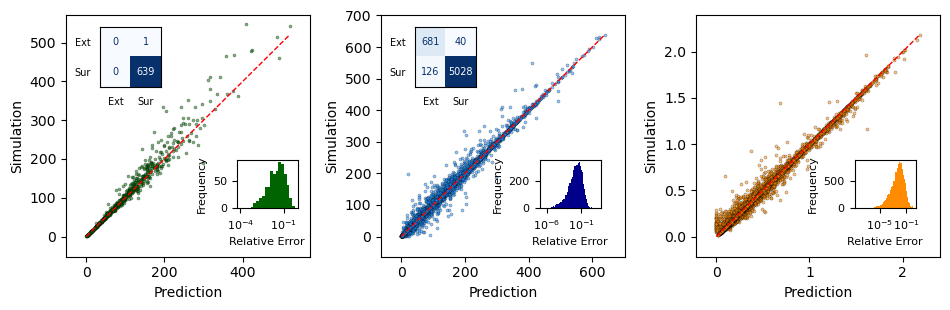

In [43]:

# Define log formatter function
# Function to format ticks as 10^(log(error))
def log_formatter(x, pos):
    return f'$10^{{{int(x)}}}$'

# Combine scatter plots and histograms
figure_width = 3.2
fig, ax = plt.subplots(1, 3, figsize=(figure_width * 3, figure_width * 1))

# Filter data for positive predictions
sim_Nbools_concatenated = np.concatenate(one_step_unpacked_data['sim_Nbool'])
prediction_Nbool_concatenated = np.concatenate(one_step_unpacked_data['prediction_Nbool'])
intersection = [a and b for a, b in zip(sim_Nbools_concatenated, prediction_Nbool_concatenated)]
positive_indices = np.array(intersection) > 0

filtered_simulationR_after = np.concatenate(one_step_unpacked_data['simulationR_after'])
filtered_predictionRs = np.concatenate(one_step_unpacked_data['Rprediction'])
filtered_simulationN_after = np.concatenate(one_step_unpacked_data['simulationN_after'])[positive_indices]
filtered_predictionNs = np.concatenate(one_step_unpacked_data['Nprediction'])[positive_indices]

# Calculate R^2 values
r2_n = r2_score(filtered_simulationN_after, filtered_predictionNs)
r2_r = r2_score(filtered_simulationR_after, filtered_predictionRs)

simulation_invader = np.array([x[-1] for x in one_step_unpacked_data['simulationN_after']])
prediction_invader = np.array([x[-1] for x in one_step_unpacked_data['Nprediction']])


sim_invader_bool = np.array([x[-1] for x in one_step_unpacked_data['sim_Nbool']])#simulation_invader > threshold_invader
pred_invader_bool = np.array([x[-1] for x in one_step_unpacked_data['prediction_Nbool']])
intersection = [a and b for a, b in zip(sim_invader_bool, pred_invader_bool)]
N0_positive_indices = np.array(intersection) > 0

# Filter N_0 data for positive predictions
filtered_simulation_invader = simulation_invader[N0_positive_indices]
filtered_prediction_invader = prediction_invader[N0_positive_indices]
r2_n0 = r2_score(filtered_simulation_invader, filtered_prediction_invader)

# Scatter plot for N_0 (still in ax[0])
maxN0 = np.max(filtered_prediction_invader)
scatter_n0 = ax[0].scatter(filtered_prediction_invader, filtered_simulation_invader, s=5, alpha=0.5, c='darkgreen', edgecolor='black',linewidth=0.3)
ax[0].plot([0, maxN0], [0, maxN0], color='r', linestyle='dashed', linewidth=1)
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Simulation')
ax[0].set_xlim(-maxN0 * 0.1, 1.1 * maxN0)
ax[0].set_ylim(-maxN0 * 0.1, 1.1 * maxN0)
#ax[0].set_title(f'invader $N_0$ ')

# Add confusion matrix inset for N_0 (still in ax[0])
inset_ax_n0 = ax[0].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_invader_bool.astype(int), pred_invader_bool.astype(int), ax=inset_ax_n0)

# Histogram for relative error of N_0 (still in ax[0])
ax_hist2 = ax[0].inset_axes([0.7, 0.2, 0.25, 0.2])
ax_hist2.hist(np.log10(np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader), bins='auto', color='darkgreen', edgecolor='none')
ax_hist2.set_xlabel('Relative Error', fontsize=8)
ax_hist2.set_ylabel('Frequency', fontsize=8)
ax_hist2.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
# Set custom x-ticks
ax_hist2.set_xticks([-4, -1])  # Replace with your desired tick positions
ax_hist2.set_xticklabels(['$10^{-4}$', '$10^{-1}$'])  # Replace with your desired tick labels


# Scatter plot for N (now moved to ax[1])
maxN = np.max(np.concatenate(one_step_unpacked_data['Nprediction']))
scatter_n = ax[1].scatter(filtered_predictionNs, filtered_simulationN_after, s=5, alpha=0.5, c='dodgerblue', edgecolor='black',linewidth=0.3)
ax[1].plot([0, maxN], [0, maxN], color='r', linestyle='dashed', linewidth=1)
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Simulation')
ax[1].set_xlim(-maxN * 0.1, 1.1 * maxN)
ax[1].set_ylim(-maxN * 0.1, 1.1 * maxN)
#ax[1].set_title(f'consumer $N_i$')

# Add confusion matrix inset for N (now in ax[1])
inset_ax_n = ax[1].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_Nbools_concatenated.astype(int), prediction_Nbool_concatenated.astype(int), ax=inset_ax_n)

# Histogram for relative error of N (now in ax[1])
ax_hist0 = ax[1].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist0.hist(np.log10(np.abs(filtered_simulationN_after - filtered_predictionNs) / filtered_simulationN_after), bins='auto', color='darkblue', edgecolor='none')
ax_hist0.set_xlabel('Relative Error', fontsize=8)
ax_hist0.set_ylabel('Frequency', fontsize=8)
ax_hist0.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist0.tick_params(axis='both', which='major', labelsize=8)
# Set custom x-ticks
ax_hist0.set_xticks([-6, -1])  # Replace with your desired tick positions
ax_hist0.set_xticklabels(['$10^{-6}$', '$10^{-1}$'])  # Replace with your desired tick labels


# Scatter plot for R (now moved to ax[2])
maxR = np.max(np.concatenate(one_step_unpacked_data['Rprediction']))
scatter_r = ax[2].scatter(filtered_predictionRs, filtered_simulationR_after, s=5, alpha=0.5, c='darkorange', edgecolor='black',linewidth=0.3)
ax[2].plot([0, maxR], [0, maxR], color='r', linestyle='dashed', linewidth=1)
ax[2].set_xlabel('Prediction')
ax[2].set_ylabel('Simulation')
ax[2].set_xlim(-maxR * 0.1, 1.1 * maxR)
ax[2].set_ylim(-maxR * 0.1, 1.1 * maxR)
#ax[2].set_title(f'resource $R_α$')

# Histogram for relative error of R (now in ax[2])
ax_hist1 = ax[2].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist1.hist(np.log10(np.abs(filtered_simulationR_after - filtered_predictionRs) / filtered_simulationR_after), bins='auto', color='darkorange', edgecolor='none')
ax_hist1.set_xlabel('Relative Error', fontsize=8)
ax_hist1.set_ylabel('Frequency', fontsize=8)
ax_hist1.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist1.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist1.set_xticks([-5, -1])  # Replace with your desired tick positions
ax_hist1.set_xticklabels(['$10^{-5}$', '$10^{-1}$'])  # Replace with your desired tick labels


plt.tight_layout()

fig.savefig("MiCRM_work.svg", format="svg")
fig.savefig("MiCRM_work.pdf", format="pdf")

plt.show()



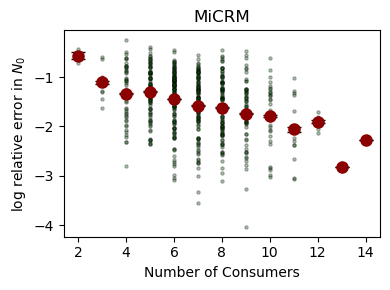

In [122]:

n_consumers=[]
similarity_score=[]
count_yes=0
count_no=0
for sim_bool, pred_bool in zip(one_step_unpacked_data['sim_Nbool'], one_step_unpacked_data['prediction_Nbool']):
    # Get intersection of where both sim and pred are True
    intersection = np.logical_and(sim_bool[:-1], pred_bool[:-1])
    # Count number of True values

    if pred_bool[-1] and sim_bool[-1]:
        n_consumers.append(np.sum(intersection))
        similarity_score.append(np.sum(intersection)/len(sim_bool))

# Create a new figure for relative error vs number of consumers
# plt.figure(figsize=(6, 4))

# Calculate relative error for N_0
relative_error_N0 = np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader


# # Create scatter plot
# plt.scatter(n_consumers, relative_error_N0, alpha=0.3, s=5, c='darkgreen', edgecolor='black')
# plt.yscale('log')

# plt.xlabel('Number of Consumers')
# plt.ylabel('Relative Error in $N_0$')
# plt.title('Relative Error vs Number of Consumers')


# plt.tight_layout()
# plt.savefig("Monod_error_vs_consumers.pdf", format="pdf")
# plt.show()

# Create arrays to store mean and percentiles for each unique number of consumers
unique_n_consumers = np.unique(n_consumers)
mean_errors = []
error_bars = []
# percentile_25 = []
# percentile_75 = []

# Calculate statistics for each unique number of consumers
for n in unique_n_consumers:
    mask = np.array(n_consumers) == n
    errors = relative_error_N0[mask]
    
    # Calculate statistics in log scale
    log_errors = np.log10(errors)
    mean_errors.append(np.mean(log_errors))
    error_bars.append(np.std(log_errors)/len(errors))



# Create new figure
plt.figure(figsize=(4, 3))

# Plot mean with error bars
plt.errorbar(unique_n_consumers, mean_errors, yerr=error_bars, 
             fmt='o', capsize=5, capthick=1, ecolor='black', 
             markersize=8, color='darkred', label='Mean with standard error')

plt.scatter(n_consumers, np.log10(relative_error_N0), alpha=0.3, s=5, c='darkgreen', edgecolor='black')

plt.xlabel('Number of Consumers')
plt.ylabel('log relative error in $N_0$')
plt.title('MiCRM')
#plt.legend()


plt.tight_layout()
plt.savefig("MiCRM_mean_error_vs_consumers.pdf", format="pdf")
plt.show()




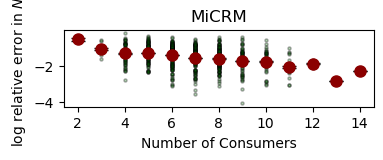

<Figure size 800x100 with 0 Axes>

In [126]:
import matplotlib.pyplot as plt
import numpy as np

n_consumers = []
similarity_score = []
count_yes = 0
count_no = 0
for sim_bool, pred_bool in zip(one_step_unpacked_data['sim_Nbool'], one_step_unpacked_data['prediction_Nbool']):
    intersection = np.logical_and(sim_bool[:-1], pred_bool[:-1])
    if pred_bool[-1] and sim_bool[-1]:
        n_consumers.append(np.sum(intersection))
        similarity_score.append(np.sum(intersection) / len(sim_bool))

relative_error_N0 = np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader

unique_n_consumers = np.unique(n_consumers)
mean_errors = []
error_bars = []

for n in unique_n_consumers:
    mask = np.array(n_consumers) == n
    errors = relative_error_N0[mask]
    log_errors = np.log10(errors)
    mean_errors.append(np.mean(log_errors))
    error_bars.append(np.std(log_errors) / len(errors))

# Create main plot with legend but do not show yet
fig, ax = plt.subplots(figsize=(4, 1))

errorbar_obj = ax.errorbar(unique_n_consumers, mean_errors, yerr=error_bars,
                          fmt='o', capsize=5, capthick=1, ecolor='black',
                          markersize=8, color='darkred', label='Mean with standard error')

scatter_obj = ax.scatter(n_consumers, np.log10(relative_error_N0), alpha=0.3, s=5,
                         c='darkgreen', edgecolor='black', label='individual systems')

ax.set_xlabel('Number of Consumers')
ax.set_ylabel('log relative error in $N_0$')
ax.set_title('MiCRM')

# Extract legend handles and labels
handles, labels = ax.get_legend_handles_labels()


# Create separate figure for legend only
fig_legend = plt.figure(figsize=(8, 1))
fig_legend.legend(handles, labels, loc='center', ncol=2, frameon=False)
fig_legend.tight_layout()
fig_legend.savefig("MiCRM_legend.pdf", format="pdf")
#plt.show()


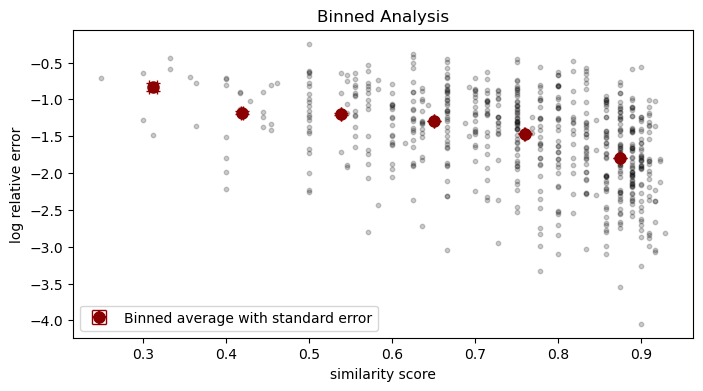

In [120]:
# plt.scatter(similarity_score, np.log10(relative_error_N0), alpha=0.2, s=40, c='darkgreen', edgecolor='black')
# plt.ylabel('log relative error')
# plt.xlabel('similairty score')

# Convert similarity_score to numpy array if it isn't already
similarity_score = np.array(similarity_score)
relative_error_N0 = np.array(relative_error_N0)

# Create bins for x and y axes
n_bins = 6
x_bins = np.linspace(min(similarity_score), max(similarity_score), n_bins+1)
y_bins = np.linspace(min(np.log10(relative_error_N0)), max(np.log10(relative_error_N0)), n_bins+1)

# Calculate bin centers
x_centers = (x_bins[:-1] + x_bins[1:]) / 2
y_centers = (y_bins[:-1] + y_bins[1:]) / 2

# Initialize arrays for means and standard deviations
x_means = []
y_means = []
x_stds = []
y_stds = []

# Calculate statistics for each bin
for i in range(n_bins):
    # Find points in current x bin
    x_mask = (similarity_score >= x_bins[i]) & (similarity_score < x_bins[i+1])
    if np.sum(x_mask) > 0:  # Only include if bin has points
        x_means.append(np.mean(similarity_score[x_mask]))
        y_means.append(np.mean(np.log10(relative_error_N0)[x_mask]))
        x_stds.append(np.std(similarity_score[x_mask])/len(similarity_score[x_mask]))
        y_stds.append(np.std(np.log10(relative_error_N0)[x_mask])/len(relative_error_N0[x_mask]))

# Convert to numpy arrays
x_means = np.array(x_means)
y_means = np.array(y_means)
x_stds = np.array(x_stds)
y_stds = np.array(y_stds)

# Create new figure
plt.figure(figsize=(8, 4))

# Plot binned data with error bars
plt.errorbar(x_means, y_means, 
            xerr=x_stds, yerr=y_stds,
            fmt='o', capsize=5, capthick=1, 
            color='darkred', markersize=8,
            label='Binned average with standard error')
plt.scatter(similarity_score, np.log10(relative_error_N0), alpha=0.2, s=10, c='black', edgecolor='black')

plt.ylabel('log relative error')
plt.xlabel('similarity score')
plt.title('Binned Analysis')
plt.legend()

#plt.tight_layout()
plt.show()


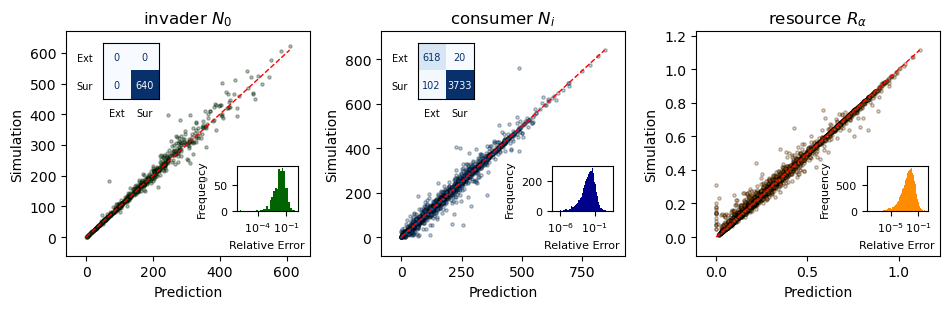

In [31]:

# Define log formatter function
# Function to format ticks as 10^(log(error))
def log_formatter(x, pos):
    return f'$10^{{{int(x)}}}$'

# Combine scatter plots and histograms
figure_width = 3.2
fig, ax = plt.subplots(1, 3, figsize=(figure_width * 3, figure_width * 1))

# Filter data for positive predictions
sim_Nbools_concatenated = np.concatenate(evolved_unpacked_data['sim_Nbool'])
prediction_Nbool_concatenated = np.concatenate(evolved_unpacked_data['prediction_Nbool'])
intersection = [a and b for a, b in zip(sim_Nbools_concatenated, prediction_Nbool_concatenated)]
positive_indices = np.array(intersection) > 0

filtered_simulationR_after = np.concatenate(evolved_unpacked_data['simulationR_after'])
filtered_predictionRs = np.concatenate(evolved_unpacked_data['Rprediction'])
filtered_simulationN_after = np.concatenate(evolved_unpacked_data['simulationN_after'])[positive_indices]
filtered_predictionNs = np.concatenate(evolved_unpacked_data['Nprediction'])[positive_indices]

# Calculate R^2 values
r2_n = r2_score(filtered_simulationN_after, filtered_predictionNs)
r2_r = r2_score(filtered_simulationR_after, filtered_predictionRs)

simulation_invader = np.array([x[-1] for x in evolved_unpacked_data['simulationN_after']])
prediction_invader = np.array([x[-1] for x in evolved_unpacked_data['Nprediction']])

# Convert continuous data to binary/categorical if necessary
threshold_invader = 0.1 # Define a threshold value if needed
sim_invader_bool = simulation_invader > threshold_invader
pred_invader_bool = prediction_invader > threshold_invader
intersection = [a and b for a, b in zip(sim_invader_bool, pred_invader_bool)]
N0_positive_indices = np.array(intersection) > 0

# Filter N_0 data for positive predictions
filtered_simulation_invader = simulation_invader[N0_positive_indices]
filtered_prediction_invader = prediction_invader[N0_positive_indices]
r2_n0 = r2_score(filtered_simulation_invader, filtered_prediction_invader)

# Scatter plot for N_0 (still in ax[0])
maxN0 = np.max(filtered_prediction_invader)
scatter_n0 = ax[0].scatter(filtered_prediction_invader, filtered_simulation_invader, s=5, alpha=0.3, c='darkgreen', edgecolors='black')
ax[0].plot([0, maxN0], [0, maxN0], color='r', linestyle='dashed', linewidth=1)
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Simulation')
ax[0].set_xlim(-maxN0 * 0.1, 1.1 * maxN0)
ax[0].set_ylim(-maxN0 * 0.1, 1.1 * maxN0)
ax[0].set_title(f'invader $N_0$ ')

# Add confusion matrix inset for N_0 (still in ax[0])
inset_ax_n0 = ax[0].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_invader_bool.astype(int), pred_invader_bool.astype(int), ax=inset_ax_n0)

# Histogram for relative error of N_0 (still in ax[0])
ax_hist2 = ax[0].inset_axes([0.7, 0.2, 0.25, 0.2])
ax_hist2.hist(np.log10(np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader), bins='auto', color='darkgreen', edgecolor='none')
ax_hist2.set_xlabel('Relative Error', fontsize=8)
ax_hist2.set_ylabel('Frequency', fontsize=8)
ax_hist2.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
# Set custom x-ticks
ax_hist2.set_xticks([-4, -1])  # Replace with your desired tick positions
ax_hist2.set_xticklabels(['$10^{-4}$', '$10^{-1}$'])  # Replace with your desired tick labels


# Scatter plot for N (now moved to ax[1])
maxN = np.max(np.concatenate(evolved_unpacked_data['Nprediction']))
scatter_n = ax[1].scatter(filtered_predictionNs, filtered_simulationN_after, s=5, alpha=0.3, c='dodgerblue', edgecolors='black')
ax[1].plot([0, maxN], [0, maxN], color='r', linestyle='dashed', linewidth=1)
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Simulation')
ax[1].set_xlim(-maxN * 0.1, 1.1 * maxN)
ax[1].set_ylim(-maxN * 0.1, 1.1 * maxN)
ax[1].set_title(f'consumer $N_i$')

# Add confusion matrix inset for N (now in ax[1])
inset_ax_n = ax[1].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_Nbools_concatenated.astype(int), prediction_Nbool_concatenated.astype(int), ax=inset_ax_n)

# Histogram for relative error of N (now in ax[1])
ax_hist0 = ax[1].inset_axes([0.7, 0.2, 0.25, 0.2])
ax_hist0.hist(np.log10(np.abs(filtered_simulationN_after - filtered_predictionNs) / filtered_simulationN_after), bins='auto', color='darkblue', edgecolor='none')
ax_hist0.set_xlabel('Relative Error', fontsize=8)
ax_hist0.set_ylabel('Frequency', fontsize=8)
ax_hist0.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist0.tick_params(axis='both', which='major', labelsize=8)
# Set custom x-ticks
ax_hist0.set_xticks([-6, -1])  # Replace with your desired tick positions
ax_hist0.set_xticklabels(['$10^{-6}$', '$10^{-1}$'])  # Replace with your desired tick labels


# Scatter plot for R (now moved to ax[2])
maxR = np.max(np.concatenate(evolved_unpacked_data['Rprediction']))
scatter_r = ax[2].scatter(filtered_predictionRs, filtered_simulationR_after, s=5, alpha=0.3, c='darkorange', edgecolors='black')
ax[2].plot([0, maxR], [0, maxR], color='r', linestyle='dashed', linewidth=1)
ax[2].set_xlabel('Prediction')
ax[2].set_ylabel('Simulation')
ax[2].set_xlim(-maxR * 0.1, 1.1 * maxR)
ax[2].set_ylim(-maxR * 0.1, 1.1 * maxR)
ax[2].set_title(f'resource $R_α$')

# Histogram for relative error of R (now in ax[2])
ax_hist1 = ax[2].inset_axes([0.7, 0.2, 0.25, 0.2])
ax_hist1.hist(np.log10(np.abs(filtered_simulationR_after - filtered_predictionRs) / filtered_simulationR_after), bins='auto', color='darkorange', edgecolor='none')
ax_hist1.set_xlabel('Relative Error', fontsize=8)
ax_hist1.set_ylabel('Frequency', fontsize=8)
ax_hist1.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist1.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist1.set_xticks([-5, -1])  # Replace with your desired tick positions
ax_hist1.set_xticklabels(['$10^{-5}$', '$10^{-1}$'])  # Replace with your desired tick labels


plt.tight_layout()

fig.savefig("evolved_cross_work.svg", format="svg")

plt.show()


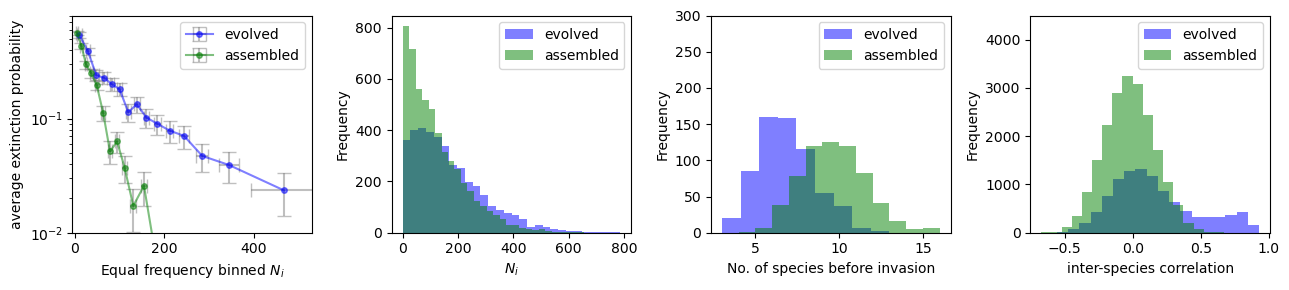

In [91]:
import numpy as np
import matplotlib.pyplot as plt

def bin_data_for_extinction_probability_equal_freq(data, ext_bool, num_bins=20):
    sorted_indices = np.argsort(data)
    sorted_data = data[sorted_indices]
    sorted_ext_bool = ext_bool[sorted_indices]

    bin_edges = np.linspace(0, len(data), num_bins + 1).astype(int)
    P_ext = []
    P_ext_errors = []
    bin_centers = []
    bin_center_errors = []

    for i in range(num_bins):
        bin_data = sorted_data[bin_edges[i]:bin_edges[i+1]]
        bin_ext_bool = sorted_ext_bool[bin_edges[i]:bin_edges[i+1]]
        
        # Calculate mean extinction probability
        mean_ext_prob = np.mean(bin_ext_bool)
        P_ext.append(mean_ext_prob)
        
        # Calculate standard error for extinction probability
        if len(bin_ext_bool) > 1:
            std_dev_y = np.std(bin_ext_bool, ddof=1)  # Sample standard deviation
            sem_y = std_dev_y / np.sqrt(len(bin_ext_bool))
        else:
            sem_y = 0
        
        P_ext_errors.append(sem_y)

        # Calculate mean and standard error for bin centers
        mean_bin_center = np.mean(bin_data)
        bin_centers.append(mean_bin_center)

        if len(bin_data) > 1:
            std_dev_x = np.std(bin_data, ddof=1)
            sem_x = std_dev_x #/ np.sqrt(len(bin_data))
        else:
            sem_x = 0
        
        bin_center_errors.append(sem_x)

    return bin_centers, P_ext, bin_center_errors, P_ext_errors

num_of_bins = 15

# First dataset
sim_Nbools_trimmed_1 = [arr[:-1] for arr in evolved_unpacked_data['sim_Nbool']]
all_Nbool_1 = np.concatenate(sim_Nbools_trimmed_1)
all_N_1 = np.concatenate(evolved_unpacked_data['simulationN_before'])
Ncenter_1, P_ext_1, Ncenter_errors_1, P_ext_errors_1 = bin_data_for_extinction_probability_equal_freq(all_N_1, np.logical_not(all_Nbool_1), num_bins=num_of_bins)

# Calculate surviving species for the first dataset
surviving_species_all_1 = [len(arr) for arr in evolved_unpacked_data['sim_Nbool']]

# Second dataset
sim_Nbools_trimmed_2 = [arr[:-1] for arr in one_step_unpacked_data['sim_Nbool']]
all_Nbool_2 = np.concatenate(sim_Nbools_trimmed_2)
all_N_2 = np.concatenate(one_step_unpacked_data['simulationN_before'])
Ncenter_2, P_ext_2, Ncenter_errors_2, P_ext_errors_2 = bin_data_for_extinction_probability_equal_freq(all_N_2, np.logical_not(all_Nbool_2), num_bins=num_of_bins)

# Calculate surviving species for the second dataset
surviving_species_all_2 = [len(arr) for arr in one_step_unpacked_data['sim_Nbool']]

# Create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 3))

# Scatter plot with error bars for extinction probabilities
ax1.errorbar(Ncenter_1, P_ext_1, xerr=Ncenter_errors_1, yerr=P_ext_errors_1,
             fmt='o', color='b', label='evolved', markersize=4, alpha=0.5, linestyle='solid', ecolor='gray', capsize=5)
ax1.errorbar(Ncenter_2, P_ext_2, xerr=Ncenter_errors_2, yerr=P_ext_errors_2,
             fmt='o', color='g', label='assembled', markersize=4, alpha=0.5,linestyle='solid', ecolor='gray', capsize=5)

ax1.set_xlabel('Equal frequency binned $N_i$')
ax1.set_ylabel('average extinction probability')
ax1.set_yscale('log')
ax1.set_ylim(0.010, 0.8)
ax1.set_xlim(-5, 530)
ax1.legend()

# Histogram with both datasets
ax2.hist(all_N_1, bins=28, color='b', alpha=0.5, label='evolved',histtype='stepfilled')
ax2.hist(all_N_2, bins=28, color='g', alpha=0.5, label='assembled',histtype='stepfilled')
ax2.set_xlabel('$N_i$')
ax2.set_ylabel('Frequency')
ax2.legend()

# Histogram of surviving species
ax3.hist(surviving_species_all_1, bins=9, color='b', alpha=0.5, label='evolved',histtype='stepfilled')
ax3.hist(surviving_species_all_2, bins=12, color='g', alpha=0.5, label='assembled',histtype='stepfilled')
ax3.set_xlabel('No. of species before invasion')
ax3.set_ylabel('Frequency')
ax3.set_ylim(0,300)
ax3.legend(loc='upper right')

# Example usage:
ax4.hist(np.concatenate(correlation_evolved),bins=18,color='b', alpha=0.5, label='evolved',histtype='stepfilled')
ax4.hist(np.concatenate(correlation_single),bins=18,color='g', alpha=0.5, label='assembled',histtype='stepfilled')
ax4.set_xlabel('inter-species correlation')
ax4.set_ylabel('Frequency')
ax4.set_ylim(0,4500)
ax4.legend(loc='upper right')


#plt.tight_layout()
plt.tight_layout()

# Save both plots to a PDF file
fig.savefig("extinction_plot.pdf", format="pdf")

plt.show()

In [ ]:
def bin_data_for_extinction_probability_by_correlation(correlations, ext_bool, num_bins=20):
    sorted_indices = np.argsort(correlations)
    sorted_correlations = correlations[sorted_indices]
    sorted_ext_bool = ext_bool[sorted_indices]

    bin_edges = np.linspace(0, len(correlations), num_bins + 1).astype(int)
    P_ext = []
    P_ext_errors = []
    bin_centers = []
    bin_center_errors = []

    for i in range(num_bins):
        bin_correlations = sorted_correlations[bin_edges[i]:bin_edges[i+1]]
        bin_ext_bool = sorted_ext_bool[bin_edges[i]:bin_edges[i+1]]
        
        # Calculate mean extinction probability
        mean_ext_prob = np.mean(bin_ext_bool)
        P_ext.append(mean_ext_prob)
        
        # Calculate standard error for extinction probability
        if len(bin_ext_bool) > 1:
            std_dev_y = np.std(bin_ext_bool, ddof=1)  # Sample standard deviation
            sem_y = std_dev_y / np.sqrt(len(bin_ext_bool))
        else:
            sem_y = 0
        
        P_ext_errors.append(sem_y)

        # Calculate mean and standard error for bin centers
        mean_bin_center = np.mean(bin_data)
        bin_centers.append(mean_bin_center)

        if len(bin_data) > 1:
            std_dev_x = np.std(bin_data, ddof=1)
            sem_x = std_dev_x #/ np.sqrt(len(bin_data))
        else:
            sem_x = 0
        
        bin_center_errors.append(sem_x)

    return bin_centers, P_ext, bin_center_errors, P_ext_errors

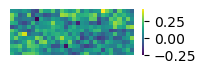

In [599]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist

# Step 1: Create a sample matrix (replace this with your actual data)
#for i in range(4):
    #matrix_data=evolved_unpacked_data['C_matrix'][i]
matrix_data = one_step_unpacked_data['C_matrix'][3]

# Convert to DataFrame for easier manipulation
matrix_df = pd.DataFrame(matrix_data, columns=[f'{i+1}' for i in range(len(matrix_data[0]))])

# Perform hierarchical clustering on rows based on their correlation
# Calculate pairwise distances between rows
row_distances = pdist(matrix_df, metric='correlation')

# Perform hierarchical clustering using the 'average' linkage method for rows
Z_rows = linkage(row_distances, method='average')

# Get the order of row indices after clustering
row_order = leaves_list(Z_rows)

# Rearrange the original DataFrame based on the row clustering order
rearranged_matrix_df = matrix_df.iloc[row_order]

# Perform hierarchical clustering on columns based on their correlation
# Calculate pairwise distances between columns (transpose the matrix)
col_distances = pdist(rearranged_matrix_df.T, metric='correlation')

# Perform hierarchical clustering using the 'average' linkage method for columns
Z_cols = linkage(col_distances, method='average')

# Get the order of column indices after clustering
col_order = leaves_list(Z_cols)

# Rearrange the DataFrame again based on both row and column clustering orders
rearranged_matrix_df = rearranged_matrix_df.iloc[:, col_order]

# Step 4: Visualize the rearranged matrix using a heatmap with a colormap
plt.figure(figsize=(2, len(matrix_data) / 20))

sns.heatmap(rearranged_matrix_df, cmap='viridis', annot=False, cbar=True)

plt.axis('off')
plt.savefig("assembled_C.pdf", format="pdf")

plt.show()

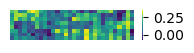

In [598]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist

# Step 1: Create a sample matrix (replace this with your actual data)
#for i in range(3):
matrix_data=evolved_unpacked_data['C_matrix'][2]
#matrix_data = one_step_unpacked_data['C_matrix'][i]

# Convert to DataFrame for easier manipulation
matrix_df = pd.DataFrame(matrix_data, columns=[f'{i+1}' for i in range(len(matrix_data[0]))])

# Perform hierarchical clustering on rows based on their correlation
# Calculate pairwise distances between rows
row_distances = pdist(matrix_df, metric='correlation')

# Perform hierarchical clustering using the 'average' linkage method for rows
Z_rows = linkage(row_distances, method='average')

# Get the order of row indices after clustering
row_order = leaves_list(Z_rows)

# Rearrange the original DataFrame based on the row clustering order
rearranged_matrix_df = matrix_df.iloc[row_order]

# Perform hierarchical clustering on columns based on their correlation
# Calculate pairwise distances between columns (transpose the matrix)
col_distances = pdist(rearranged_matrix_df.T, metric='correlation')

# Perform hierarchical clustering using the 'average' linkage method for columns
Z_cols = linkage(col_distances, method='average')

# Get the order of column indices after clustering
col_order = leaves_list(Z_cols)

# Rearrange the DataFrame again based on both row and column clustering orders
rearranged_matrix_df = rearranged_matrix_df.iloc[:, col_order]

# Step 4: Visualize the rearranged matrix using a heatmap with a colormap
plt.figure(figsize=(2, len(matrix_data) / 20))

sns.heatmap(rearranged_matrix_df, cmap='viridis', annot=False, cbar=True)

plt.axis('off')
plt.savefig("evolved_C.pdf", format="pdf")

plt.show()

In [44]:
def shift_invader_impacts(unpacked_data):
    # Extract data from unpacked_data
    invader_abundance = [arr[-1] for arr in unpacked_data['simulationN_after']]
    
    simulationN_before = unpacked_data['simulationN_before']
    simulationN_after = unpacked_data['simulationN_after']
    sim_Nbools = unpacked_data['sim_Nbool']
    simulationR_before = unpacked_data['simulationR_before']
    simulationR_after = unpacked_data['simulationR_after']
    #naive_invasion_fitness = unpacked_data['naive_invasion_fitness']
    screened_invader_impact_N = unpacked_data['screened_invader_impact_N']
    screened_invader_impact_R = unpacked_data['screened_invader_impact_R']

    # Calculate N_shifts
    N_shifts = []
    for i in range(len(simulationN_before)):
        N_sur_before = simulationN_before[i][sim_Nbools[i][:-1]]
        N_sur_after = simulationN_after[i][sim_Nbools[i]][:-1]
        N_shifts.append(N_sur_after - N_sur_before)
    
    # Calculate R_shifts
    R_shifts = []
    for i in range(len(simulationR_before)):
        R_sur_before = simulationR_before[i]
        R_sur_after = simulationR_after[i]
        R_shifts.append(R_sur_after - R_sur_before)
    
    # Calculate weighted_invader_impact_N
    weighted_invader_impact_N = []
    for scalar, vector in zip(invader_abundance, screened_invader_impact_N):
        weighted_invader_impact_N.append(scalar * vector)
    
    # Calculate weighted_invader_impact_R
    weighted_invader_impact_R = []
    for scalar, vector in zip(invader_abundance, screened_invader_impact_R):
        weighted_invader_impact_R.append(scalar * vector)
    
    return N_shifts, R_shifts, weighted_invader_impact_N, weighted_invader_impact_R


In [13]:
def generate_sample_indices(data_length, fraction):
    """
    Generates random sample indices for downsampling.

    Parameters:
    - data_length: int, the length of the dataset.
    - fraction: float, the fraction of data to retain (between 0 and 1).

    Returns:
    - indices: list, randomly selected indices for downsampling.
    """
    if not (0 < fraction <= 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    num_samples = int(data_length * fraction)
    return np.random.choice(data_length, num_samples, replace=False)

def downsample_data(unpacked_data, fraction):
    """
    Downsamples the given dataset by a specified fraction using consistent indices.

    Parameters:
    - unpacked_data: dict, containing arrays to be downsampled.
    - fraction: float, the fraction of data to retain (between 0 and 1).

    Returns:
    - downsampled_data: dict, containing the downsampled arrays.
    """
    # Assume all datasets have the same length; use the first key to determine this
    first_key = next(iter(unpacked_data))
    data_length = len(unpacked_data[first_key])
    
    # Generate sample indices once
    sample_indices = generate_sample_indices(data_length, fraction)
    
    downsampled_data = {}
    
    for key, data in unpacked_data.items():
        # Convert data to a numpy array if it isn't one already
        data_array = np.array(data, dtype=object) if not isinstance(data, np.ndarray) else data
        
        # Use the same sample indices for consistency
        downsampled_data[key] = data_array[sample_indices]
    
    return downsampled_data


In [1]:
downsampled_data = downsample_data(evolved_unpacked_data, 0.5)
N_shifts, R_shifts, weighted_invader_impact_N, weighted_invader_impact_R=shift_invader_impacts(downsampled_data)


figure_width = 3
fig, ax = plt.subplots(1, 2, figsize=(figure_width * 2.4, figure_width))

num_ext_list = []
for sim_Nbool in downsampled_data['sim_Nbool']:
    Nextbool = np.logical_not(sim_Nbool)
    num_ext_list.append(sum(Nextbool))

# Extend the color to the same length of shifts
Nextended_num_ext_list = []
for i in range(len(num_ext_list)):
    Nextended_num_ext_list += [num_ext_list[i]] * len(N_shifts[i])

Rextended_num_ext_list = []
for i in range(len(num_ext_list)):
    Rextended_num_ext_list += [num_ext_list[i]] * len(R_shifts[i])

# Flatten arrays for sorting
x1 = -np.concatenate(weighted_invader_impact_N)
y1 = np.concatenate(N_shifts)

x2 = -np.concatenate(weighted_invader_impact_R)
y2 = np.concatenate(R_shifts)

# Create structured arrays for sorting
N_data = np.array(list(zip(Nextended_num_ext_list, x1, y1)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])
R_data = np.array(list(zip(Rextended_num_ext_list, x2, y2)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])

# Sort data by number of extinctions in descending order
sorted_N_data = np.sort(N_data, order='extinctions')[::-1]
sorted_R_data = np.sort(R_data, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_Nextinctions = sorted_N_data['extinctions']
sorted_x1 = sorted_N_data['x']
sorted_y1 = sorted_N_data['y']

sorted_Rextinctions = sorted_R_data['extinctions']
sorted_x2 = sorted_R_data['x']
sorted_y2 = sorted_R_data['y']

# # Define boundaries and colormap
# # Create colormap that starts from -1.5 but uses boundaries from 0
# custom_colors = plt.cm.jet(np.linspace(0, 1, 256))  # Get jet colormap colors
# custom_colors[0:int(256*(1.5/9))] = custom_colors[0]  # Make all colors below 0 the same
# custom_cmap = ListedColormap(custom_colors)

boundaries = np.arange(-1.5, 7.5)
norm = BoundaryNorm(boundaries, ncolors=256)

# Create the scatter plot with discrete colors for the first plot
scatter1 = ax[0].scatter(sorted_x1, sorted_y1,
                         s=5,
                         c=sorted_Nextinctions,
                         cmap='jet',
                         alpha=1,
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.07)

ax[0].set_ylabel('Consumer shifts')
ax[0].set_xlabel('Consumer shifts due to invader')
ax[0].set_ylim(-500, 200)
ax[0].set_xlim(-500, 200)

# Add dashed line where x=y for the first plot
max_limit_1 = max(sorted_x1.max(), sorted_y1.max())
min_limit_1 = min(sorted_x1.min(), sorted_y1.min())
ax[0].plot([min_limit_1, max_limit_1], [min_limit_1, max_limit_1], color='gray', linestyle='dashed', linewidth=0.5)

# Add a separate axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
cbar = fig.colorbar(scatter1, cax=cbar_ax, boundaries=boundaries,
                    ticks=np.arange(np.min(sorted_Nextinctions), np.max(sorted_Nextinctions) + 1))
cbar.set_label('Number of Extinctions')

# Create the scatter plot with discrete colors for the second plot
scatter2 = ax[1].scatter(sorted_x2, sorted_y2,
                         s=5,
                         alpha=1,
                         c=sorted_Rextinctions,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.07)

ax[1].set_ylabel('Resource shifts')
ax[1].set_xlabel('Resource shifts due to invader')

# Add dashed line where x=y for the second plot
max_limit_2 = max(sorted_x2.max(), sorted_y2.max())
min_limit_2 = min(sorted_x2.min(), sorted_y2.min())
ax[1].plot([min_limit_2, max_limit_2], [min_limit_2, max_limit_2], color='gray', linestyle='dashed', linewidth=0.5)
ax[1].set_ylim(-0.5, 0.5)
ax[1].set_xlim(-0.5, 0.5)

plt.subplots_adjust(wspace=0.5)
plt.savefig('shift_colorful_plot.pdf', bbox_inches='tight')
plt.show()

NameError: name 'downsample_data' is not defined

In [40]:
downsampled_data = downsample_data(one_step_unpacked_data, 0.5)
N_shifts, R_shifts, weighted_invader_impact_N, weighted_invader_impact_R=shift_invader_impacts(downsampled_data)


figure_width = 3
fig, ax = plt.subplots(1, 2, figsize=(figure_width * 2.4, figure_width))

num_ext_list = []
for sim_Nbool in downsampled_data['sim_Nbool']:
    Nextbool = np.logical_not(sim_Nbool)
    num_ext_list.append(sum(Nextbool))

# Extend the color to the same length of shifts
Nextended_num_ext_list = []
for i in range(len(num_ext_list)):
    Nextended_num_ext_list += [num_ext_list[i]] * len(N_shifts[i])

Rextended_num_ext_list = []
for i in range(len(num_ext_list)):
    Rextended_num_ext_list += [num_ext_list[i]] * len(R_shifts[i])

# Flatten arrays for sorting
x1 = -np.concatenate(weighted_invader_impact_N)
y1 = np.concatenate(N_shifts)

x2 = -np.concatenate(weighted_invader_impact_R)
y2 = np.concatenate(R_shifts)

# Create structured arrays for sorting
N_data = np.array(list(zip(Nextended_num_ext_list, x1, y1)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])
R_data = np.array(list(zip(Rextended_num_ext_list, x2, y2)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])

# Sort data by number of extinctions in descending order
sorted_N_data = np.sort(N_data, order='extinctions')[::-1]
sorted_R_data = np.sort(R_data, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_Nextinctions = sorted_N_data['extinctions']
sorted_x1 = sorted_N_data['x']
sorted_y1 = sorted_N_data['y']

sorted_Rextinctions = sorted_R_data['extinctions']
sorted_x2 = sorted_R_data['x']
sorted_y2 = sorted_R_data['y']

# Define boundaries and colormap
boundaries = np.arange(-1.5, 7.5)
norm = BoundaryNorm(boundaries, ncolors=256)

# Create the scatter plot with discrete colors for the first plot
scatter1 = ax[0].scatter(sorted_x1, sorted_y1,
                         s=5,
                         c=sorted_Nextinctions,
                         cmap='jet',
                         alpha=1,
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.07)

ax[0].set_ylabel('Consumer shifts')
ax[0].set_xlabel('Consumer shifts due to invader')
ax[0].set_ylim(-500, 200)
ax[0].set_xlim(-500, 200)

# Add dashed line where x=y for the first plot
max_limit_1 = max(sorted_x1.max(), sorted_y1.max())
min_limit_1 = min(sorted_x1.min(), sorted_y1.min())
ax[0].plot([min_limit_1, max_limit_1], [min_limit_1, max_limit_1], color='gray', linestyle='dashed', linewidth=0.5)

# Add a separate axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
cbar = fig.colorbar(scatter1, cax=cbar_ax, boundaries=boundaries,
                    ticks=np.arange(np.min(sorted_Nextinctions), np.max(sorted_Nextinctions) + 1))
cbar.set_label('Number of Extinctions')

# Create the scatter plot with discrete colors for the second plot
scatter2 = ax[1].scatter(sorted_x2, sorted_y2,
                         s=5,
                         alpha=1,
                         c=sorted_Rextinctions,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.07)

ax[1].set_ylabel('Resource shifts')
ax[1].set_xlabel('Resource shifts due to invader')

# Add dashed line where x=y for the second plot
max_limit_2 = max(sorted_x2.max(), sorted_y2.max())
min_limit_2 = min(sorted_x2.min(), sorted_y2.min())
ax[1].plot([min_limit_2, max_limit_2], [min_limit_2, max_limit_2], color='gray', linestyle='dashed', linewidth=0.5)
ax[1].set_ylim(-0.5, 0.5)
ax[1].set_xlim(-0.5, 0.5)

plt.subplots_adjust(wspace=0.5)
plt.savefig('one_step_shift_colorful_plot.pdf', bbox_inches='tight')
plt.show()

NameError: name 'shift_invader_impacts' is not defined

In [18]:
downsampled_data = downsample_data(evolved_unpacked_data, 0.5)

# Calculate the number of extinctions
num_ext_list = []
for sim_Nbool in downsampled_data['sim_Nbool']:
    Nextbool = np.logical_not(sim_Nbool)
    num_ext_list.append(sum(Nextbool))

figure_width = 3
fig, ax = plt.subplots(1, 2, figsize=(figure_width * 2.4, figure_width))

# # Define boundaries and colormap
# boundaries = np.arange(-1.5, 7.5)
# norm = BoundaryNorm(boundaries, ncolors=256)
# Define boundaries and colormap
# Create colormap that starts from -1.5 but uses boundaries from 0
custom_colors = plt.cm.jet(np.linspace(0, 1, 256))  # Get jet colormap colors
custom_colors[0:int(256*(1.5/9))] = custom_colors[0]  # Make all colors below 0 the same
custom_cmap = ListedColormap(custom_colors)

invader_abundance = np.array([arr[-1] for arr in downsampled_data['simulationN_after']])

# Data for the first plot
x1 = -1 * np.multiply(np.concatenate(downsampled_data['naive_invasion_fitness']),
                      np.concatenate(np.concatenate(downsampled_data['Minv'])))
y1 = invader_abundance

# Create a structured array for sorting
data1 = np.array(list(zip(num_ext_list, x1, y1)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])

# Sort data by number of extinctions in descending order
sorted_data1 = np.sort(data1, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_num_ext_list_1 = sorted_data1['extinctions']
sorted_x1 = sorted_data1['x']
sorted_y1 = sorted_data1['y']

# Create the scatter plot with discrete colors for the first plot
scatter1 = ax[0].scatter(sorted_x1, sorted_y1,
                         s=10,
                         c=sorted_num_ext_list_1,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.1)

# Add dashed line where x=y for the first plot
max_limit_1 = max(sorted_x1.max(), sorted_y1.max())
min_limit_1 = min(sorted_x1.min(), sorted_y1.min())
ax[0].plot([min_limit_1, max_limit_1], [min_limit_1, max_limit_1], color='gray', linestyle='dashed', linewidth=0.5)

ax[0].set_ylabel('Invader Abundance')
ax[0].set_xlabel('Dressed Invasion Fitness')
ax[0].set_xlim(-10, 450)

# Add a separate axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
cbar = fig.colorbar(scatter1, cax=cbar_ax, boundaries=boundaries,
                    ticks=np.arange(np.min(sorted_num_ext_list_1), np.max(sorted_num_ext_list_1) + 1))
cbar.set_label('Number of Extinctions')

# Data for the second plot
x2 = np.concatenate(downsampled_data['naive_invasion_fitness'])
y2 = invader_abundance

# Create a structured array for sorting
data2 = np.array(list(zip(num_ext_list, x2, y2)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])

# Sort data by number of extinctions in descending order
sorted_data2 = np.sort(data2, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_num_ext_list_2 = sorted_data2['extinctions']
sorted_x2 = sorted_data2['x']
sorted_y2 = sorted_data2['y']

# Create the scatter plot with discrete colors for the second plot
scatter2 = ax[1].scatter(sorted_x2, sorted_y2,
                         s=10,
                         alpha=1,
                         c=sorted_num_ext_list_2,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.1)

ax[1].set_ylabel('Invader Abundance')
ax[1].set_xlabel('Invasion Fitness')

plt.subplots_adjust(wspace=0.5)
plt.savefig('colorful_plot.pdf', bbox_inches='tight')
plt.show()

NameError: name 'evolved_unpacked_data' is not defined

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 131 has size 0

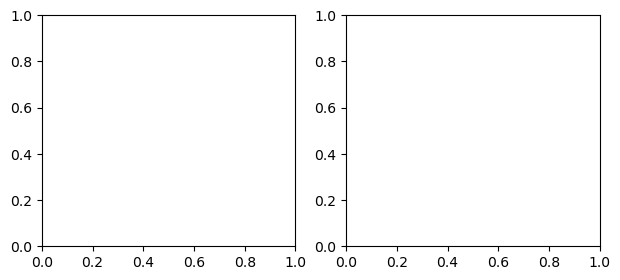

In [39]:
from matplotlib.colors import ListedColormap

downsampled_data = downsample_data(one_step_unpacked_data, 0.5)

# Calculate the number of extinctions
num_ext_list = []
for sim_Nbool in downsampled_data['sim_Nbool']:
    Nextbool = np.logical_not(sim_Nbool)
    num_ext_list.append(sum(Nextbool))

figure_width = 3
fig, ax = plt.subplots(1, 2, figsize=(figure_width * 2.4, figure_width))

# # Define boundaries and colormap
boundaries = np.arange(-1.5, 7.5)
norm = BoundaryNorm(boundaries, ncolors=256)


# Define boundaries and colormap
# # Create colormap that starts from -1.5 but uses boundaries from 0
# custom_colors = plt.cm.jet(np.linspace(0, 1, 256))  # Get jet colormap colors
# custom_colors[0:int(256*(1.5/9))] = custom_colors[0]  # Make all colors below 0 the same
# custom_cmap = ListedColormap(custom_colors)
# Set colorbar limits to match data range
#cbar.ax.set_ylim(3+np.min(sorted_num_ext_list_1), np.max(sorted_num_ext_list_1))

invader_abundance = np.array([arr[-1] for arr in downsampled_data['simulationN_after']])

# Data for the first plot
x1 = -1 * np.multiply(np.concatenate(downsampled_data['naive_invasion_fitness']),
                      np.concatenate(np.concatenate(downsampled_data['Minv'])))
y1 = invader_abundance

# Create a structured array for sorting
data1 = np.array(list(zip(num_ext_list, x1, y1)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])

# Sort data by number of extinctions in descending order
sorted_data1 = np.sort(data1, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_num_ext_list_1 = sorted_data1['extinctions']
sorted_x1 = sorted_data1['x']
sorted_y1 = sorted_data1['y']
# Create the scatter plot with discrete colors for the first plot
scatter1 = ax[0].scatter(sorted_x1, sorted_y1,
                         s=10,
                         c=sorted_num_ext_list_1,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.1)

# Add dashed line where x=y for the first plot
max_limit_1 = max(sorted_x1.max(), sorted_y1.max())
min_limit_1 = min(sorted_x1.min(), sorted_y1.min())
ax[0].plot([min_limit_1, max_limit_1], [min_limit_1, max_limit_1], color='gray', linestyle='dashed', linewidth=0.5)

ax[0].set_ylabel('Invader Abundance')
ax[0].set_xlabel('Dressed Invasion Fitness')
ax[0].set_xlim(-10, 450)

# Add a separate axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
cbar = fig.colorbar(scatter1, cax=cbar_ax, boundaries=boundaries,
                    ticks=np.arange(np.min(sorted_num_ext_list_1), np.max(sorted_num_ext_list_1) + 1))
cbar.set_label('Number of Extinctions')

# Data for the second plot
x2 = np.concatenate(downsampled_data['naive_invasion_fitness'])
y2 = invader_abundance

# Create a structured array for sorting
data2 = np.array(list(zip(num_ext_list, x2, y2)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])

# Sort data by number of extinctions in descending order
sorted_data2 = np.sort(data2, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_num_ext_list_2 = sorted_data2['extinctions']
sorted_x2 = sorted_data2['x']
sorted_y2 = sorted_data2['y']

# Create the scatter plot with discrete colors for the second plot
scatter2 = ax[1].scatter(sorted_x2, sorted_y2,
                         s=10,
                         alpha=1,
                         c=sorted_num_ext_list_2,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.1)

ax[1].set_ylabel('Invader Abundance')
ax[1].set_xlabel('Invasion Fitness')

plt.subplots_adjust(wspace=0.5)
plt.savefig('one_step_colorful_plot.pdf', bbox_inches='tight')
plt.show()

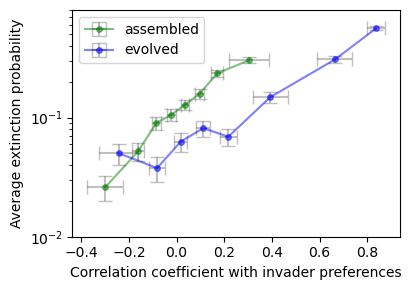

In [93]:
def correlation_with_CI(C_matrix, C_I):
    # Ensure inputs are numpy arrays
    C_matrix = np.array(C_matrix)
    C_I = np.array(C_I)
    
    # Calculate correlation coefficient between each row of C_matrix and C_I
    correlations = []
    for row in C_matrix:
        corr = np.corrcoef(row, C_I)[0,1]
        correlations.append(corr)
    
    return correlations

# Calculate correlations for one-step matrices
CI_correlations_single = []
for i in range(len(one_step_unpacked_data['C_matrix'])):
    CI_correlations_single.append(
        correlation_with_CI(
            one_step_unpacked_data['C_matrix'][i],
            one_step_unpacked_data['C_I'][i]
        )
    )

# Calculate correlations for evolved matrices  
CI_correlations_evolved = []
for i in range(len(evolved_unpacked_data['C_matrix'])):
    CI_correlations_evolved.append(
        correlation_with_CI(
            evolved_unpacked_data['C_matrix'][i], 
            evolved_unpacked_data['C_I'][i]
        )
    )
# Flatten the correlation arrays and get corresponding extinction data
all_correlations_single = np.concatenate(CI_correlations_single)
all_correlations_evolved = np.concatenate(CI_correlations_evolved)

# Get extinction data
sim_Nbools_trimmed_single = [arr[:-1] for arr in one_step_unpacked_data['sim_Nbool']]
all_Nbool_single = np.concatenate(sim_Nbools_trimmed_single)

sim_Nbools_trimmed_evolved = [arr[:-1] for arr in evolved_unpacked_data['sim_Nbool']]
all_Nbool_evolved = np.concatenate(sim_Nbools_trimmed_evolved)

# Calculate extinction probabilities using the binning function
num_of_bins = 8
corr_centers_single, P_ext_single, corr_errors_single, P_ext_errors_single = bin_data_for_extinction_probability_equal_freq(
    all_correlations_single, 
    np.logical_not(all_Nbool_single), 
    num_bins=num_of_bins
)

corr_centers_evolved, P_ext_evolved, corr_errors_evolved, P_ext_errors_evolved = bin_data_for_extinction_probability_equal_freq(
    all_correlations_evolved,
    np.logical_not(all_Nbool_evolved),
    num_bins=num_of_bins
)

# Create plot
plt.figure(figsize=(4.2, 3))
plt.errorbar(corr_centers_single, P_ext_single, 
             xerr=corr_errors_single, yerr=P_ext_errors_single,
             fmt='o', color='g', label='assembled', markersize=4, 
             alpha=0.5, linestyle='solid', ecolor='gray', capsize=5)

plt.errorbar(corr_centers_evolved, P_ext_evolved, 
             xerr=corr_errors_evolved, yerr=P_ext_errors_evolved,
             fmt='o', color='b', label='evolved', markersize=4, 
             alpha=0.5, linestyle='solid', ecolor='gray', capsize=5)

plt.xlabel('Correlation coefficient with invader preferences')
plt.ylabel('Average extinction probability')
plt.yscale('log')
plt.ylim(0.010, 0.8)
plt.legend()
plt.tight_layout()
plt.savefig('extinction prob versus correlation.pdf', bbox_inches='tight')

plt.show()
